$u^"_{tt} = u^"_{xx}(x, t), \: 0 \leq x \leq 1, \: 0 \leq t \leq 0.5$

$u(0, t) = 0, \: u(1, t) = 0$

$u(x, 0) = (ax^2 + 1.1)sin(\pi x), \: u'_t(x, 0) = 0$

$a = 1.1 + 0.1k, \: k = 0, 1, 2, 3, 4$

Точное решение задачи по формуле Даламбера:

$u(x, t) = \frac{1}{2}\phi (x + t) + \frac{1}{2}\phi (x - t)$

$\phi (2n + x ) = (ax^2 + 1.1)sin(\pi x)$

$\phi (2n - x ) = -(ax^2 + 1.1)sin(\pi x)$

Сведем к системе уравнений акустики:
$$
\begin{equation}
    \begin{cases}
        u'_t - v'_x = 0\\
        v'_t - u'_x = 0\\
        u(x, 0) = (ax^2 + 1.1)sin(\pi x)\\
        v(x, 0) = 0\\
        u(0, t) = u(1, t) = 0\\
    \end{cases}
\end{equation}
$$

Будем решать методом с разнесенной сетокой и параметрами $\xi_1 = \frac{1}{2}, \:\xi_2 = \frac{1}{2}$, чтобы был второй порядок аппроксимации и схема была безусловно устойчива.

$\frac{y_m^{n + 1} - y_m^n}{t} = \frac{1}{2}(\frac{z^{n + 1}_m - z^{n + 1}_{m - 1}}{h} + \frac{z^{n}_m - z^{n}_{m - 1}}{h})$

$\frac{z_m^{n + 1} - z_m^n}{t} = \frac{1}{2}(\frac{y^{n + 1}_{m + 1} - y^{n + 1}_{m}}{h} + \frac{y^{n}_{m + 1} - y^{n}_{m}}{h})$

$y_m^0 = (a(mh)^2 + 1.1)sin(\pi mh)$

$y_0^n = y_M^n = 0$

$z^0_m = 0$

Это можно на каждом шаге решать как трехдиагональную систему с неизвестным вектором $w = (y_0, z_0, ..., z_{M - 1}, y_{M})$

Для устойчивости прогонки достаточно требовать, чтобы $\frac{t}{h} < 1$

In [1]:
import numpy as np
import matplotlib as plt
import math
import matplotlib.pyplot

In [50]:
num_nodes = 800
k = 1
a = 1.1 + 0.1 * k
T = 0.5
h = 1.0 / num_nodes
M = num_nodes + 1
t = h / 2
N = int(T / t) + 1
w_curr = np.zeros((2 * M - 1), dtype = float) 
w_prev = np.zeros((2 * M - 1), dtype = float)
x = [i * h for i in range(0, M)]
for i in range(0, 2 * M - 1):
    if i % 2 == 0:
        w_prev[i] = (a * x[i / 2] * x[i / 2] + 1.1) * math.sin(math.pi * x[i / 2]) #начальные условия
A = [] # В прогонке все, кроме столбца правой части можно заполнить заранее
B = []
C = []
A.append(0.0)
B.append(0.0)
C.append(1.0)
for i in range(1, 2 * M - 2):
        A.append(1.0 / (2 * h))
        C.append(1.0 / t)
        B.append(- 1.0 / (2 * h))
A.append(0.0)
B.append(0.0)
C.append(1.0)
for n in range(1, N):
    F = []
    F.append(0.0)
    for i in range(1, 2 * M - 2):
        F.append(w_prev[i] / t + (w_prev[i + 1] - w_prev[i - 1]) / (2 * h))
    F.append(0.0)
    alfa = np.zeros(2 * M - 1, dtype = float)
    beta = np.zeros(2 * M - 1, dtype = float)
    alfa[1] = -B[0] / C[0]
    beta[1] = F[0] / C[0]
    for i in range(2, 2 * M - 1):
        alfa[i] = -B[i - 1] / (A[i - 1] * alfa[i - 1] + C[i - 1])
        beta[i] = (F[i - 1] - A[i - 1] * beta[i - 1]) / (A[i - 1] * alfa[i - 1] + C[i - 1])
    w_curr[2 * M - 2] = (F[2 * M - 2] - A[2 * M - 2] * beta[2 * M - 2]) / (C[2 * M - 2] + A[2 * M - 2] * alfa[2 * M - 2])
    for i in range(2 * M - 3, -1, -1):
        w_curr[i] = alfa[i + 1] * w_curr[i + 1] + beta[i + 1]
    for m in range(0, 2 * M - 1):
        w_prev[m] = w_curr[m]


In [51]:
y = [w_curr[i] for i in range(0, 2 * M - 1, 2)]

In [52]:
y_exact = np.zeros(M, dtype = float) 
for i in range(M):
    if (x[i] + T) < 1.0:
        y_exact[i] = (1.0 / 2) * ((a * (x[i] + T) * (x[i] + T) + 1.1) * math.sin(math.pi * (x[i] + T)) + (a * (x[i] - T) * (x[i] - T) + 1.1) * math.sin(math.pi * (x[i] - T)))
    else:
        z = 2.0 - (x[i] + T)
        y_exact[i] = (1.0 / 2) * (-(a * z * z + 1.1) * math.sin(math.pi * z) + (a * (x[i] - T) * (x[i] - T) + 1.1) * math.sin(math.pi * (x[i] - T)))
        

9.861864287161702e-05


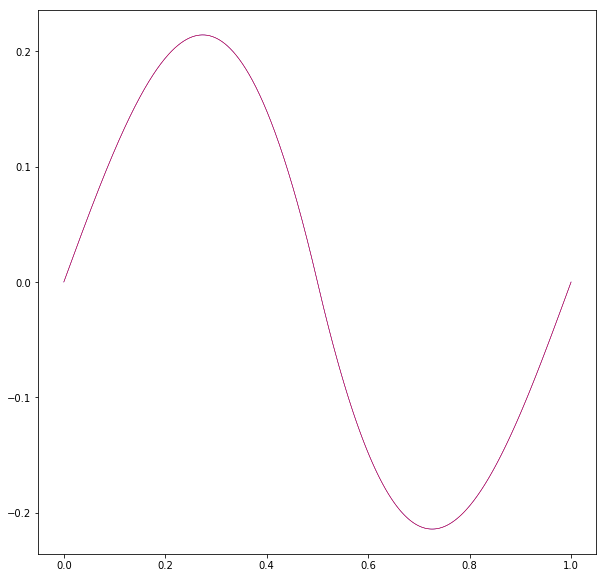

In [53]:
plt.pyplot.figure(figsize=(10,10))
err = max(abs(y_exact - y))
print(err)
plt.pyplot.plot(x, y, c = 'b', linewidth = 0.5)
plt.pyplot.plot(x, y_exact, c = 'r', linewidth = 0.5)
plt.pyplot.show()